---
# 3. CNN *FROM SCRATCH*

In [22]:
# Gestión y extracción de archivos
import os
import pandas as pd
import numpy as np
import random
import zipfile
import shutil
from tensorflow.keras.utils import image_dataset_from_directory

# Visualización de imágenes
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import json


# Red neuronal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPool2D, PReLU
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.initializers import GlorotUniform

# Ajuste de hiperparámetros
import keras_tuner as kt
import visualkeras

# Evaluación de resultados
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

---
## 3.1. Funciones auxiliares

En esta sección incluimos una serie de utilidades que nos servirán para gestionar tanto el proceso de entrenamiento como la evaluación de los modelos. Estas funciones nos permitirán:

- Entrenar redes neuronales con la posibilidad de activar el mecanismo de *Early Stopping* para evitar sobreajuste;
- Generar predicciones a partir de un modelo entrenado;
- Visualizar de forma clara la evolución del *loss* y la *accuracy* durante las distintas épocas de entrenamiento y validación;
- Evaluar el rendimiento del modelo utilizando métricas clásicas y una matriz de confusión interpretativa.

In [2]:
def train_model(model, bs = 128, eps = 50, early_stopping = True, pat = 3,
                min_d = 0.001):
    """
    Ejecuta el proceso de entrenamiento del modelo durante un número determinado de épocas.
    Se puede activar la parada temprana (Early Stopping) para evitar el sobreajuste.

    :param keras.engine.functional.Functional model: modelo que se desea entrenar
    :param int bs: tamaño de los batches durante el entrenamiento
    :param int eps: número máximo de épocas a ejecutar
    :param bool early_stopping: indica si se desea utilizar la técnica de Early Stopping
    :param int pat: número de épocas consecutivas sin mejora permitidas antes de detener el entrenamiento
    :param float min_d: mejora mínima en la función de pérdida para ser considerada significativa
    """
    
    early_stop = None

    if early_stopping == True:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=pat,
            min_delta=min_d,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            train_set,
            epochs=eps,
            validation_data=val_set,
            batch_size=bs,
            class_weight=CLASS_WEIGHTS,
            callbacks=[early_stop],
            verbose=1
        )
    
    else:
        history = model.fit(
            train_set,
            epochs=eps,
            validation_data=val_set,
            batch_size=bs,
            class_weight=CLASS_WEIGHTS,
            verbose=1
        )

    return history, early_stop

In [3]:
def plot_history(history, early_stop=None, plot_size=(15, 5)):
    """
    Muestra información útil sobre el entrenamiento del modelo, incluyendo:
    - Detalles básicos como el número total de épocas y la mejor época alcanzada;
    - Dos gráficos que permiten analizar cómo evolucionaron la función de pérdida (loss) 
      y la precisión (accuracy) tanto en entrenamiento como en validación.

    :param keras.callbacks.History history: objeto que guarda los valores de loss y accuracy por época
    :param keras.callbacks.EarlyStopping early_stop: callback de early stopping usado durante el entrenamiento
    :param tuple plot_size: tamaño de la figura que se va a mostrar
    """

    if early_stop is not None:
        if early_stop.stopped_epoch != 0:
            epochs = early_stop.stopped_epoch + 1
        else:
            early_stop.best_epoch + 1
        best_epoch = early_stop.best_epoch + 1
    else:
        epochs = len(history.epoch)
        best_epoch = epochs

    fig = plt.figure(figsize=plot_size)

    # Gráfico de evolución de la pérdida
    plt.subplot(1, 2, 1)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la pérdida')
    plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
    plt.plot(range(0, best_epoch), history.history['loss'][:best_epoch], '.-', color="C0")
    plt.plot(range(0, best_epoch), history.history['val_loss'][:best_epoch], '.-', color="C1")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['loss'][best_epoch-1:], '.--', color="C0")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['val_loss'][best_epoch-1:], '.--', color="C1")
    plt.legend(['Entrenamiento', 'Validación'])

    # Gráfico de evolución de la precisión
    plt.subplot(1, 2, 2)
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Evolución de la precisión')
    plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
    plt.plot(range(0, best_epoch), history.history['accuracy'][:best_epoch], '.-', color="C0")
    plt.plot(range(0, best_epoch), history.history['val_accuracy'][:best_epoch], '.-', color="C1")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['accuracy'][best_epoch-1:], '.--', color="C0")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['val_accuracy'][best_epoch-1:], '.--', color="C1")
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

    # Resumen de resultados
    print('Resumen del entrenamiento:\n')
    print('Número total de épocas:', epochs)
    print('Época con mejor resultado (weights restaurados):', best_epoch)
    print('Accuracy en entrenamiento (época ' + str(best_epoch) + '): ' + str(history.history['accuracy'][best_epoch - 1]))
    print('Accuracy en validación (época ' + str(best_epoch) + '): ' + str(history.history['val_accuracy'][best_epoch - 1]))
    print('Loss en entrenamiento (época ' + str(best_epoch) + '): ' + str(history.history['loss'][best_epoch - 1]))
    
    index = history.history['val_loss'].index(min(history.history['val_loss']))
    print('Loss en validación (época ' + str(best_epoch) + '): ' + str(history.history['val_loss'][index]))
    print('\n\n')

In [4]:
def make_prediction(model, test_set):
    """
    Genera las predicciones del modelo sobre el conjunto de prueba.

    :param keras.engine.functional.Functional model: modelo entrenado que se utiliza para hacer la clasificación
    :param BatchDataset test_set: conjunto de datos de prueba sobre el que se realizarán las predicciones
    :return: array con las clases predichas para cada imagen del conjunto de prueba
    """
    y_prediction = model.predict(test_set)
    y_pred = []
    for i in range(len(y_prediction)):
        y_pred.append(np.argmax(y_prediction[i]))
    y_pred = np.array(y_pred)

    return y_pred

In [5]:
def evaluate_prediction(model, y_test, y_pred, labels, plot_size=(15, 15)):
    """
    Calcula e interpreta las métricas de evaluación de un modelo de clasificación, 
    mostrando el informe de clasificación y la matriz de confusión en forma gráfica.

    :param keras.engine.functional.Functional model: modelo de Keras previamente entrenado
    :param array y_test: etiquetas reales del conjunto de prueba
    :param array y_pred: etiquetas predichas por el modelo
    :param list labels: lista con los nombres de las clases (pintores en este caso)
    :param tuple plot_size: tamaño de la figura de la matriz de confusión
    """
    # Informe de clasificación
    cl = classification_report(y_test, y_pred, target_names=labels)
    print('\nInforme de clasificación\n', cl)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=plot_size)
    sns.heatmap(cm, annot=True, fmt='g', cmap="PuRd")
    ax.set_title('Matriz de confusión')
    ax.set_xlabel('Etiquetas predichas')
    ax.set_ylabel('Etiquetas reales')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')

---
## 3.2. Neural Network from Scratch

Para comenzar con el desarrollo del proyecto, se optó en primer lugar por construir una red neuronal desde cero. Este modelo inicial sirve como punto de partida o referencia (*baseline*) para comparar con enfoques más sofisticados posteriormente.

Una vez definida, entrenada y evaluada esta primera red, se procedió a optimizar su rendimiento ajustando algunos de sus hiperparámetros mediante técnicas de *fine-tuning*.  
En las dos secciones que siguen se recoge el código que implementa ambas fases: la construcción básica del modelo y su posterior ajuste.

---
### 3.2.1. Carga de datos

Como ya se hizo en el notebook de EDA, vamos a definir una función para cargar las imágenes del dataset de forma estructurada. Durante la carga, las imágenes se redimensionan a un tamaño uniforme de **224×224 píxeles**, lo que facilita su procesamiento posterior por las redes neuronales.  
Los datos se agrupan en *batches* de tamaño **64**, y se reserva un **10%** del conjunto de entrenamiento para validación mediante el parámetro `validation_split`.

In [11]:
def import_data(train_path, test_path, img_size=(224, 224), batch_size=64,
                val_split=0.1):
    """
    Importa las imágenes para los conjuntos de entrenamiento, validación y prueba
    utilizando la función image_dataset_from_directory de Keras.

    :param tuple img_size: tamaño al que se redimensionarán las imágenes
    :param int batch_size: tamaño de los lotes (batches) para los conjuntos
    :param float val_split: proporción del conjunto de entrenamiento reservada para validación
    :param str train_path: ruta de la carpeta que contiene las imágenes de entrenamiento
    :param str test_path: ruta de la carpeta que contiene las imágenes de prueba
    """
    
    print('=========== CONJUNTO DE TRAINING ===========')
    train_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='training',
        seed=1)

    print('\n\n=========== CONJUNTO DE VALIDACIÓN ===========')
    val_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='validation',
        seed=1)

    print('\n\n=========== CONJUNTO DE TEST ===========')
    test_set = keras.preprocessing.image_dataset_from_directory(
        test_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False,
        seed=1)

    return train_set, val_set, test_set

In [12]:
train_set, val_set, test_set = import_data(train_path = "data/" + "Train",
                                           test_path = "data/" + "Test")

=========== CONJUNTO DE TRAINING ===========
Found 3178 files belonging to 10 classes.
Using 2861 files for training.


=========== CONJUNTO DE VALIDACIÓN ===========
Found 3178 files belonging to 10 classes.
Using 317 files for validation.


=========== CONJUNTO DE TEST ===========
Found 793 files belonging to 10 classes.


In [13]:
# Inspección de las dimensiones de los elementos del dataset
train_set.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

In [14]:
# Extracción de las etiquetas  del conjunto de test
y_test = np.concatenate([y for x, y in test_set], axis=0)
y_test = [np.argmax(l) for l in y_test]

2025-05-04 21:23:27.923993: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 10

---
### 3.2.2. Visualización del contenido del dataset

A continuación se muestra una visualización de 9 pinturas seleccionadas aleatoriamente del dataset.  
Como se puede observar, las imágenes fueron redimensionadas y ahora todas tienen el mismo tamaño: **224 × 224 píxeles**.

2025-05-04 21:25:44.303731: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


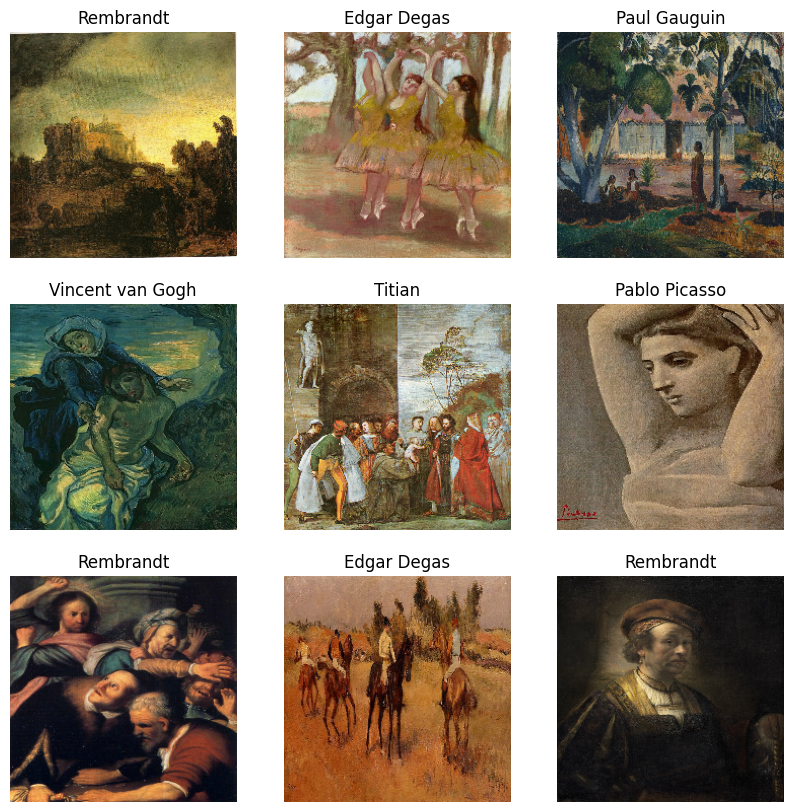

In [16]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):  # Solo 1 batch para mostrar 9 imágenes
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Obtener índice del pintor
        author_index = tf.argmax(labels[i]).numpy()
        author = class_names[author_index].split('_')

        # Reconstruir nombre del pintor
        title = ' '.join(author)
        plt.title(title)
        plt.axis("off")

---
### 3.2.3 Modelo *baseline*

Como primer paso se desarrolló una red neuronal sencilla desde cero, con el objetivo de establecer una base comparativa frente a arquitecturas más avanzadas que se probarán más adelante.  
El diseño del modelo se inspira en una propuesta recogida en [Viswanathan (2017)](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf).

La red recibe imágenes de entrada de tamaño $(224 \times 224 \times 3)$ y está formada por dos bloques convolucionales. Cada bloque contiene capas con 32 filtros de tamaño $3 \times 3$, aplicados con un *stride* de 2. Tras cada bloque convolucional se añade una capa de *max pooling* con filtros $2 \times 2$ para reducir progresivamente la dimensionalidad espacial de las imágenes.

Después de los bloques convolucionales, se utiliza una capa *flatten* que transforma la salida en un vector unidimensional, seguida por una capa totalmente conectada (*fully connected*) con 228 neuronas. Finalmente, se incluye una capa de salida con 10 unidades (una por clase), utilizando la función de activación *softmax* para permitir la clasificación multiclase.

Dado que el problema consiste en asignar una única clase entre varias posibles, se ha utilizado como función de pérdida la *categorical crossentropy*, adecuada para este tipo de tareas.

In [17]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 10

Cargamos los pesos que hallamos en el notebook 1.- EDA

In [29]:
with open('class_weights.json', 'r', encoding='utf-8') as f:
    raw = json.load(f)

# Convierte las claves de str a int
CLASS_WEIGHTS = {int(k): v for k, v in raw.items()}
CLASS_WEIGHTS


{0: 0.44548044548044546,
 1: 0.556454221934649,
 2: 0.8909608909608909,
 3: 1.1625549172017573,
 4: 1.193615544760583,
 5: 1.2559328221978825,
 6: 1.3421771361685524,
 7: 1.4891774891774892,
 8: 1.5107597716293368,
 9: 1.5329768270944741,
 10: 1.6373155640171346}

In [24]:
### Red neuronal baseline ###

# Reinicio de la sesión actual de Keras
keras.backend.clear_session()

# Capa de entrada
in_ = keras.Input(shape=INPUT_SHAPE)

# Primer bloque convolucional
conv_1 = Conv2D(32, kernel_size=3, strides=2, padding='same',
                activation='relu')(in_)
pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

# Segundo bloque convolucional
conv_2 = Conv2D(32, kernel_size=3, strides=2, padding='same',
                activation='relu')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

# Capa completamente conectada
fl = Flatten()(pool_2)
fc_1 = Dense(228, activation='relu')(fl)
out_ = Dense(NUM_CLASSES, activation='softmax')(fc_1)

# Definición del modelo
baseline = keras.Model(inputs=in_, outputs=out_)

# Compilación del modelo
baseline.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.Adam(0.0015),
                 metrics=['accuracy', Recall(name='recall')])

A continuación se muestra una representación esquemática de la red que acabamos de definir.

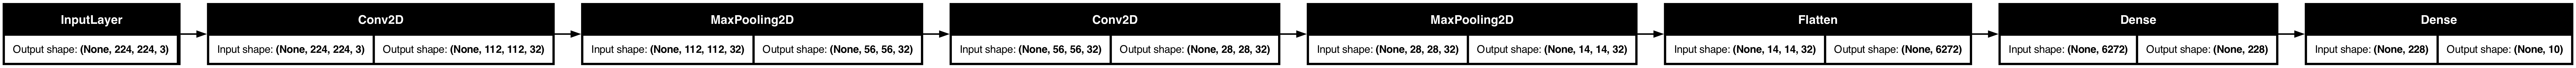

In [25]:
keras.utils.plot_model(baseline, show_shapes=True, rankdir= 'LR')

Utilizando la función `train_model` definida anteriormente, se ha llevado a cabo el entrenamiento de la red `baseline` durante un total de 50 épocas.

In [34]:
base_h, base_es = train_model(baseline, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50


33/45 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5516 - loss: 1.2687 - recall: 0.3862

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5589 - loss: 1.2480 - recall: 0.3954 - val_accuracy: 0.3533 - val_loss: 2.3181 - val_recall: 0.2429
Epoch 2/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6268 - loss: 1.0894 - recall: 0.4965

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6427 - loss: 1.0364 - recall: 0.5152 - val_accuracy: 0.3722 - val_loss: 2.3085 - val_recall: 0.2776
Epoch 3/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7430 - loss: 0.7313 - recall: 0.6377

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7468 - loss: 0.7169 - recall: 0.6440 - val_accuracy: 0.3943 - val_loss: 2.7551 - val_recall: 0.3438
Epoch 4/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7960 - loss: 0.5797 - recall: 0.7178

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7937 - loss: 0.5824 - recall: 0.7142 - val_accuracy: 0.3943 - val_loss: 2.9539 - val_recall: 0.3502
Epoch 5/50
38/45 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8313 - loss: 0.4908 - recall: 0.7711

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.8324 - loss: 0.4934 - recall: 0.7716 - val_accuracy: 0.3596 - val_loss: 3.0717 - val_recall: 0.2934
Epoch 6/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8550 - loss: 0.4245 - recall: 0.7995

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.8591 - loss: 0.4180 - recall: 0.8049 - val_accuracy: 0.3754 - val_loss: 3.0325 - val_recall: 0.3060
Epoch 7/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8809 - loss: 0.3564 - recall: 0.8361

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8807 - loss: 0.3596 - recall: 0.8362 - val_accuracy: 0.3565 - val_loss: 3.4889 - val_recall: 0.2839
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


Durante el entrenamiento del modelo se aplicó la técnica de *early stopping*, que permite interrumpir el proceso automáticamente cuando no se observa una mejora significativa en la pérdida del conjunto de validación.  
En concreto, si durante 5 épocas consecutivas (`patience = 5`) la *val_loss* no mejora al menos en `min_delta = 0.01`, el entrenamiento se detiene.  
En este caso, el modelo alcanzó su mejor resultado en la segunda época, pero no consiguió mejorar en las  siguientes, por lo que el entrenamiento se interrumpió automáticamente tras solo 7 épocas.

Este comportamiento se puede apreciar con más detalle en los gráficos que se muestran a continuación.

Resumen del entrenamiento:

Número total de épocas: 7
Época con mejor resultado (weights restaurados): 2
Accuracy en entrenamiento (época 2): 0.686822772026062
Accuracy en validación (época 2): 0.37223973870277405
Loss en entrenamiento (época 2): 0.8904450535774231
Loss en validación (época 2): 2.3084540367126465





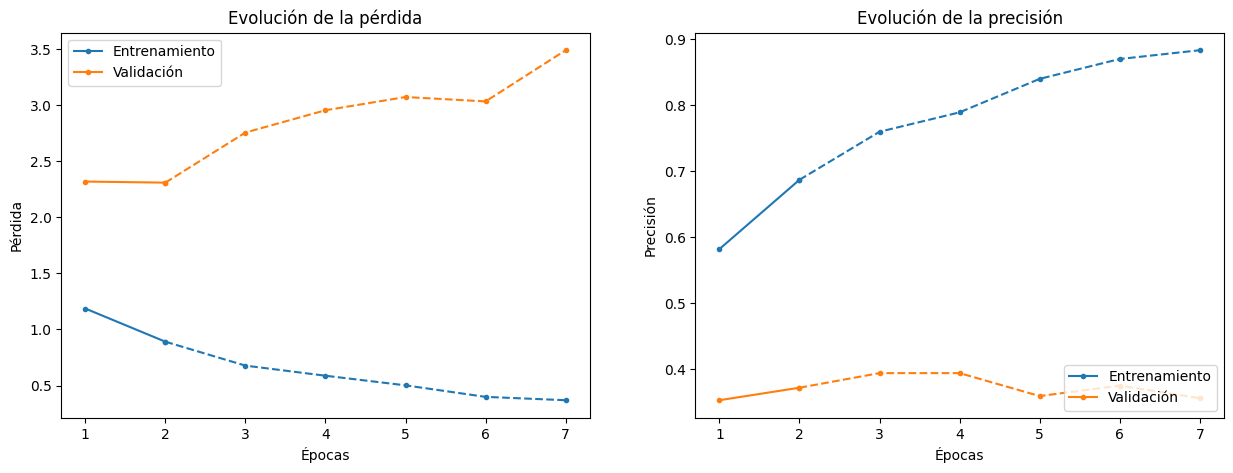

In [35]:
plot_history(base_h, early_stop = base_es)

Tal y como se puede observar en los gráficos, a partir de la segunda época las curvas de entrenamiento y validación —tanto de *accuracy* como de *loss*— comienzan a separarse de forma progresiva, lo que indica un aumento del sobreajuste.  
No obstante, gracias al mecanismo de *early stopping*, el proceso de entrenamiento se interrumpió a tiempo y se restauraron automáticamente los pesos correspondientes a la segunda época, que fue donde el modelo alcanzó su mejor desempeño en validación.

In [37]:
base_pred = make_prediction(baseline, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.33      0.02      0.04        52
          Edgar_Degas       0.53      0.44      0.48       140
       Francisco_Goya       0.42      0.29      0.35        58
         Marc_Chagall       0.50      0.44      0.47        48
        Pablo_Picasso       0.21      0.17      0.19        88
         Paul_Gauguin       0.20      0.11      0.14        62
Pierre-Auguste_Renoir       0.21      0.15      0.17        67
            Rembrandt       0.47      0.54      0.50        52
               Titian       0.41      0.25      0.31        51
     Vincent_van_Gogh       0.32      0.63      0.43       175

             accuracy                           0.36       793
            macro avg       0.36      0.31      0.31       793
         weighted avg       0.36      0.36      0.34       793



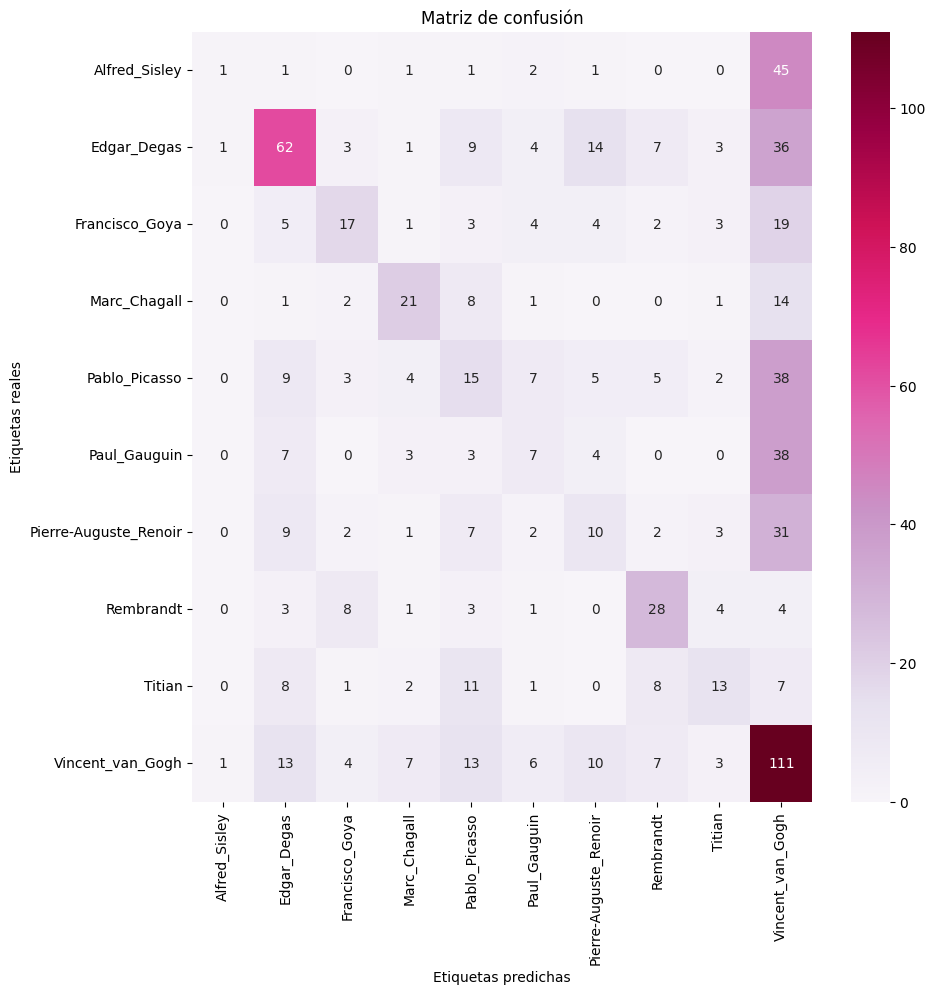

In [39]:
labels = train_set.class_names
evaluate_prediction(baseline, y_test, base_pred, labels, plot_size = (10,10))

---
### 3.2.4. Modelo *baseline* | Optimización de hiperparámetros

Con el objetivo de mejorar el rendimiento que acabamos de alcanzar con la red neuronal `baseline`, se van a ajustar sus hiperparámetros e incluso contemplar la posibilidad de incorporar nuevas capas al modelo.  
Para ello, vamos a utilizar la librería `keras_tuner`, una herramienta de Python que permite definir un espacio de búsqueda de configuraciones posibles y seleccionar automáticamente la combinación más adecuada en función de un criterio de evaluación determinado (como la precisión o la pérdida de validación).

In [41]:
early_stop = EarlyStopping(monitor ='val_loss', patience = 3, min_delta = 15e-4,
                           verbose = 1, restore_best_weights = True) 

# Para asegurar que los resultados se puedan reproducir, se fija una semilla aleatoria
initializer = GlorotUniform(seed=1234)

La siguiente función establece el espacio de búsqueda que se explorará para encontrar la mejor combinación posible de hiperparámetros.

In [44]:
def build_model(hp):
    
  # Reinicia la sesión de Keras para garantizar que no haya residuos de modelos anteriores
  keras.backend.clear_session()

  model = keras.models.Sequential()

  # Capa de entrada
  model.add(keras.Input(shape=INPUT_SHAPE))
  
  ### DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS ###
  act_functions = ["relu", "tanh"]
  n_filters = [16, 32, 64, 128]
  kernel_sz = [3, 5]
  drop_rate = [0.0, 0.2, 0.3]
  n_units = [64, 128, 256]
  opt_functions = ['adam', 'SGD']
  
  pool_sz = (2, 2)

  ### CONSTRUCCIÓN DEL MODELO ###

  # Selección de función de activación
  hp_act_function = hp.Choice('activation', values=act_functions, default='relu')
  if hp_act_function == 'PReLU':
    act_f = get_custom_objects().update({'PReLU': PReLU()})
  else:
    act_f = hp_act_function

  # Número de bloques convolucionales a incluir
  hp_n_conv = hp.Int('num_conv', min_value=1, max_value=3, step=1, default=2)
  
  for i in range(hp_n_conv):
    # Elección del número de filtros
    hp_filter = hp.Choice(f'filter_{i}', values=n_filters, default=32)
    # Elección del tamaño del kernel
    hp_kernel_sz = hp.Choice(f'size_{i}', values=kernel_sz, default=3)

    # Añade una capa convolucional
    model.add(
        Conv2D(hp_filter, hp_kernel_sz, strides=2, padding="same",
               activation=act_f, kernel_initializer=initializer))
    # Añade una capa de max pooling para reducir dimensiones
    model.add(
        MaxPool2D(pool_size=pool_sz))
    
  # Dropout tras los bloques convolucionales (si procede)
  hp_dropout_rate_1 = hp.Choice('dropout_1', values=drop_rate, default=0.2)
  if hp_dropout_rate_1 != 0:
    model.add(Dropout(hp_dropout_rate_1))

  # Aplanamiento de los mapas de características
  model.add(Flatten())
  
  # ¿Agregar capas densas adicionales antes de la salida?
  hp_add_dense = hp.Boolean('add_dense')
  if hp_add_dense:
    # Número de capas densas adicionales
    hp_n_dense = hp.Int('num_dense', min_value=1, max_value=2, step=1,
                        default=1, parent_name='add_dense', parent_values=[True])
    
    for i in range(hp_n_dense):
      # Unidades por capa densa
      uns = hp.Choice(f"units_{i}", values=n_units, default=128)
      # Función de activación a usar
      act_f = hp.Choice(f"activation_{i}", ['relu', 'PReLU'])

      # Añadir la capa densa
      model.add(Dense(units=uns, activation=act_f))
    
    # Dropout tras las capas densas (si procede)
    hp_dropout_rate_2 = hp.Choice('dropout_2', values=drop_rate, default=0.3)
    if hp_dropout_rate_2 != 0:
      model.add(Dropout(hp_dropout_rate_2))

  # Capa densa adicional previa a la salida
  uns = hp.Choice('units_dense', values=n_units, default=64)
  act_f = hp.Choice("activation", ["relu", "tanh"])
  model.add(Dense(units=uns, activation=act_f))

  # Capa de salida con activación softmax
  model.add(Dense(NUM_CLASSES, activation="softmax", kernel_initializer=initializer))

  # Configuración del optimizador
  hp_optimizer = hp.Choice('optimizer', values=opt_functions, default='adam')
  opt_f = keras.optimizers.get(hp_optimizer)
  # Definición del learning rate
  opt_f.learning_rate = hp.Float("lr", min_value=5e-4, max_value=2e-3, sampling="log")
  
  model.compile(optimizer=opt_f,
                loss="categorical_crossentropy",
                metrics=["accuracy", Recall(name='recall')])

  return model

A continuación creamos una instancia del *tuner* bayesiano, que se encargará de buscar la mejor combinación de hiperparámetros dentro del espacio definido en la función `build_model`.  
Este proceso evaluará un total de **25 configuraciones distintas**, con el objetivo de encontrar aquella que ofrezca la mayor precisión posible sobre el conjunto de validación.

In [47]:
# Inicialización del tuner
num_classes = NUM_CLASSES
tuner = kt.BayesianOptimization(build_model,
                                objective = kt.Objective('val_accuracy',
                                                         direction = "max"),
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name = 'baseline_opt')

In [48]:
# Visualización del espacio de búsqueda de hiperparámetros 
tuner.search_space_summary()

Search space summary
Default search space size: 11
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_conv (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filter_0 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
size_0 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filter_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.0, 0.2, 0.3], 'ordered': True}
add_dense (Boolean)
{'default': False, 'conditions': []}
units_dense (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}
lr (Float)
{'

Se han definido una serie de variables que constituyen el espacio de búsqueda de hiperparámetros para el modelo `baseline`. Estas variables permiten explorar distintas configuraciones que podrían mejorar el rendimiento de la red. En concreto:

- **`activation`**: permite seleccionar la función de activación para las capas convolucionales.
- **`filter_i`** y **`size_i`**: determinan respectivamente la cantidad de filtros y el tamaño de cada filtro en las capas convolucionales.
- **`units_dense`**: especifica el número de neuronas en la capa densa final, justo antes de la capa de salida.
- **`optimizer`** y **`lr`**: controlan el tipo de optimizador y la tasa de aprendizaje utilizada durante el entrenamiento.

Además, como parte del análisis vamos a evaluar si añadir o eliminar bloques convolucionales, así como insertar capas adicionales —como capas totalmente conectadas (*fully connected*) o de *dropout*— podía mejorar los resultados. Para ello se incorporaron nuevos hiperparámetros:

- **`num_conv`**: permite ajustar cuántos bloques convolucionales se incluyen en la arquitectura.
- **`dropout_1`**: establece el porcentaje de desactivación de neuronas tras las capas convolucionales; solo se aplica si su valor es distinto de 0.
- **`add_dense`**: variable booleana que indica si deben añadirse capas densas adicionales al modelo.

Si el valor de `add_dense` es `True`, se habilitan cuatro nuevas variables en el espacio de búsqueda:

- **`num_dense`**: define cuántas capas densas se añaden, con un rango de 1 a 2.
- **`units_i`** y **`activation_i`**: controlan el número de neuronas y la función de activación para la capa densa número `i`.
- **`dropout_2`**: especifica el ratio de desactivación para una segunda capa de *dropout*, aplicada después de las capas densas añadidas (solo si su valor es distinto de 0).

In [55]:
import tensorflow as tf

# Comprobación de GPU compatible (Apple Silicon con Metal o CUDA en otros sistemas)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ TensorFlow detectó la(s) GPU:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("⚠️ TensorFlow no detectó GPU. Usará la CPU.")

⚠️ TensorFlow no detectó GPU. Usará la CPU.


In [59]:
# Búsqueda de la mejor configuración de hiperparámetros
tuner.search(train_set, epochs = 25, validation_data = val_set, shuffle = True,
             callbacks = [early_stop], class_weight = CLASS_WEIGHTS)

Trial 25 Complete [00h 01m 53s]
val_accuracy: 0.24290220439434052

Best val_accuracy So Far: 0.4637224078178406
Total elapsed time: 01h 06m 06s


Tras entrenar un total de 25 redes distintas durante 25 épocas cada una —considerando además los pesos definidos en `CLASS_WEIGHTS` para compensar el desbalanceo de clases— vamos a identificar la combinación óptima de hiperparámetros para el modelo.

In [60]:
# Mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'activation': 'tanh',
 'num_conv': 1,
 'filter_0': 32,
 'size_0': 5,
 'filter_1': 128,
 'size_1': 5,
 'dropout_1': 0.2,
 'add_dense': False,
 'units_dense': 128,
 'optimizer': 'SGD',
 'lr': 0.0006680774061198157,
 'filter_2': 32,
 'size_2': 5,
 'units_0': 128,
 'activation_0': 'relu',
 'dropout_2': 0.2}

El modelo resultante de la mejor combinación de hiperparámetros encontrada durante el proceso de optimización es el siguiente.

In [61]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,848,906 (49.01 MB)

 Trainable params: 12,848,906 (49.01 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
best_model.save('baseline_best.h5')


La imagen mostrada a continuación representa de forma esquemática la arquitectura del modelo configurado por el optimizador. 
A continuación, procederemos a su reentrenamiento.

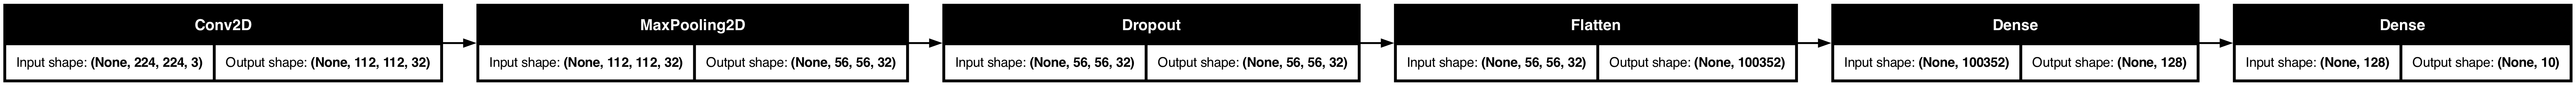

In [63]:
tuned_model = tuner.hypermodel.build(best_hps)

keras.utils.plot_model(tuned_model, show_shapes = True, rankdir= 'LR')

El entrenamiento del nuevo modelo `tuned_model`, optimizado con el optimizador *adam* y una tasa de aprendizaje de $0.0005$, se ha llevado a cabo durante 50 épocas. Se ha mantenido el uso de *early stopping*, configurado con un `patience=5` y una mejora mínima requerida `min_delta=0.0015`.

In [64]:
# Entrenamiento del modelo optimizado | 50 épocas con EarlyStopping
tuned_h, tuned_es = train_model(tuned_model, eps = 50,
                                early_stopping = True, pat = 5, min_d = 15e-4)

Epoch 1/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.1745 - loss: 2.8101 - recall: 0.0191

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.1809 - loss: 2.7559 - recall: 0.0165 - val_accuracy: 0.2429 - val_loss: 2.1260 - val_recall: 0.0000e+00
Epoch 2/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.1947 - loss: 2.3725 - recall: 0.0021

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.2055 - loss: 2.3569 - recall: 0.0043 - val_accuracy: 0.2334 - val_loss: 2.1010 - val_recall: 0.0221
Epoch 3/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.2353 - loss: 2.2692 - recall: 0.0211

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.2388 - loss: 2.2634 - recall: 0.0220 - val_accuracy: 0.2871 - val_loss: 1.9619 - val_recall: 0.0694
Epoch 4/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.2603 - loss: 2.1920 - recall: 0.0471

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.2628 - loss: 2.1915 - recall: 0.0479 - val_accuracy: 0.3028 - val_loss: 1.9672 - val_recall: 0.1325
Epoch 5/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.2800 - loss: 2.1658 - recall: 0.0524

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.2813 - loss: 2.1587 - recall: 0.0535 - val_accuracy: 0.2744 - val_loss: 2.0633 - val_recall: 0.1924
Epoch 6/50
27/45 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.2751 - loss: 2.1615 - recall: 0.0563

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.2844 - loss: 2.1409 - recall: 0.0599 - val_accuracy: 0.3091 - val_loss: 1.9722 - val_recall: 0.1388
Epoch 7/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.2871 - loss: 2.1160 - recall: 0.0750

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.2927 - loss: 2.1061 - recall: 0.0756 - val_accuracy: 0.2618 - val_loss: 2.2794 - val_recall: 0.2240
Epoch 8/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.3165 - loss: 2.0697 - recall: 0.0766

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.3197 - loss: 2.0585 - recall: 0.0789 - val_accuracy: 0.3565 - val_loss: 1.7916 - val_recall: 0.0662
Epoch 9/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.3413 - loss: 1.9964 - recall: 0.0753

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.3436 - loss: 1.9880 - recall: 0.0803 - val_accuracy: 0.3502 - val_loss: 1.8248 - val_recall: 0.1640
Epoch 10/50
38/45 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.3543 - loss: 1.9288 - recall: 0.0913

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.3574 - loss: 1.9228 - recall: 0.0942 - val_accuracy: 0.3943 - val_loss: 1.7121 - val_recall: 0.1104
Epoch 11/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.3809 - loss: 1.8521 - recall: 0.1098

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.3813 - loss: 1.8621 - recall: 0.1129 - val_accuracy: 0.3281 - val_loss: 1.8650 - val_recall: 0.2050
Epoch 12/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.3672 - loss: 1.9212 - recall: 0.1094

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.3692 - loss: 1.9097 - recall: 0.1124 - val_accuracy: 0.3218 - val_loss: 1.8169 - val_recall: 0.0662
Epoch 13/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.4155 - loss: 1.7759 - recall: 0.1311

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.4105 - loss: 1.7915 - recall: 0.1313 - val_accuracy: 0.4448 - val_loss: 1.6932 - val_recall: 0.1703
Epoch 14/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.4120 - loss: 1.7669 - recall: 0.1188

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.4138 - loss: 1.7700 - recall: 0.1282 - val_accuracy: 0.2650 - val_loss: 1.9902 - val_recall: 0.0536
Epoch 15/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4296 - loss: 1.7907 - recall: 0.1362

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.4317 - loss: 1.7774 - recall: 0.1430 - val_accuracy: 0.4069 - val_loss: 1.7139 - val_recall: 0.2019
Epoch 16/50
26/45 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.4347 - loss: 1.6958 - recall: 0.1794

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.4463 - loss: 1.6807 - recall: 0.1849 - val_accuracy: 0.3407 - val_loss: 1.8630 - val_recall: 0.1893
Epoch 17/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4340 - loss: 1.7200 - recall: 0.1677

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.4461 - loss: 1.6919 - recall: 0.1759 - val_accuracy: 0.4290 - val_loss: 1.7254 - val_recall: 0.1956
Epoch 18/50
38/45 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.4950 - loss: 1.5734 - recall: 0.2230

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.4919 - loss: 1.5767 - recall: 0.2221 - val_accuracy: 0.3849 - val_loss: 1.7055 - val_recall: 0.1136
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


Al igual que en el modelo anterior, el mecanismo de *early stopping* detuvo el entrenamiento tras 18 épocas, conservando como configuración óptima la obtenida en la época número 13.  
No obstante, a pesar del buen rendimiento sobre el conjunto de entrenamiento, se observa un cierto sobreajuste a partir de la decimocuarta época.  
Aun así, puede apreciarse que el nuevo modelo supera en desempeño al modelo `baseline`.

Resumen del entrenamiento:

Número total de épocas: 18
Época con mejor resultado (weights restaurados): 13
Accuracy en entrenamiento (época 13): 0.40754979848861694
Accuracy en validación (época 13): 0.4447949528694153
Loss en entrenamiento (época 13): 1.8100522756576538
Loss en validación (época 13): 1.6932309865951538





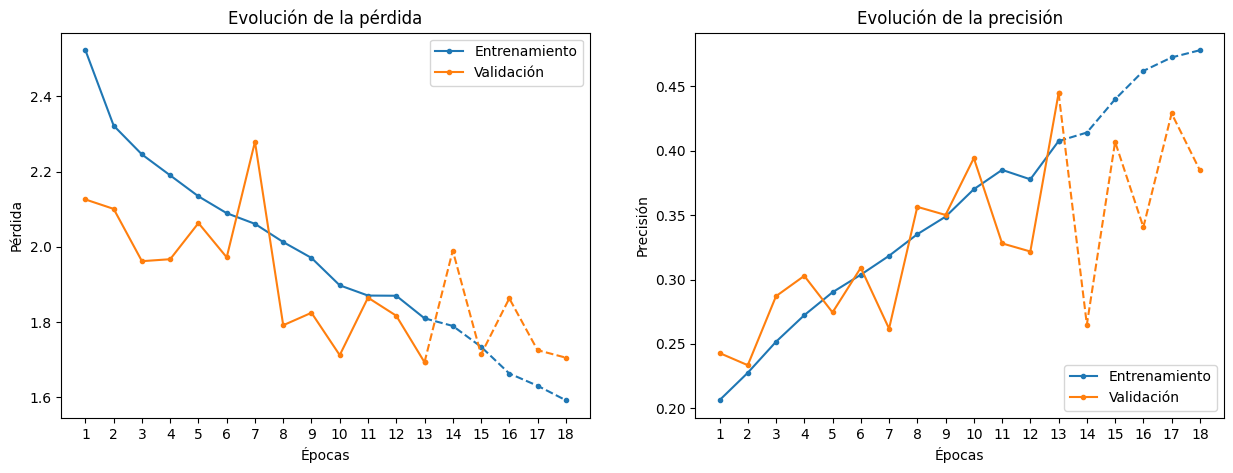

In [65]:
plot_history(tuned_h, early_stop = tuned_es)

In [66]:
tuned_pred = make_prediction(tuned_model, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


Una vez realizada la clasificación sobre el conjunto de test, vamos a evaluar los resultados obtenidos.  
Si observamos la siguiente matriz de confusión, y la comparamos con la anterior, se puede notar que los valores están ahora algo más concentrados en la diagonal principal, lo cual indica una mayor precisión en las predicciones. La red alcanzó una *accuracy* del **44%**.

Apreciamos una mejora clara, por ejemplo, en la clase `Vicent Van Gogh`: en el modelo actual logró un *recall* del **82%**, mientras que en el modelo `baseline` la sensibilidad para esta clase apenas alcanzaba el **63%**.  
En efecto, las imágenes de `Vicent Van Gogh` que anteriormente eran clasificadas erróneamente como pertenecientes a `Pablo Picasso`, ahora son asignadas de forma incorrecta con menor frecuencia gracias al modelo optimizado.


Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       1.00      0.04      0.07        52
          Edgar_Degas       0.48      0.49      0.48       140
       Francisco_Goya       0.37      0.31      0.34        58
         Marc_Chagall       0.72      0.44      0.55        48
        Pablo_Picasso       0.54      0.08      0.14        88
         Paul_Gauguin       0.47      0.15      0.22        62
Pierre-Auguste_Renoir       0.32      0.12      0.17        67
            Rembrandt       0.26      0.40      0.31        52
               Titian       0.71      0.10      0.17        51
     Vincent_van_Gogh       0.34      0.82      0.48       175

             accuracy                           0.38       793
            macro avg       0.52      0.29      0.29       793
         weighted avg       0.48      0.38      0.33       793



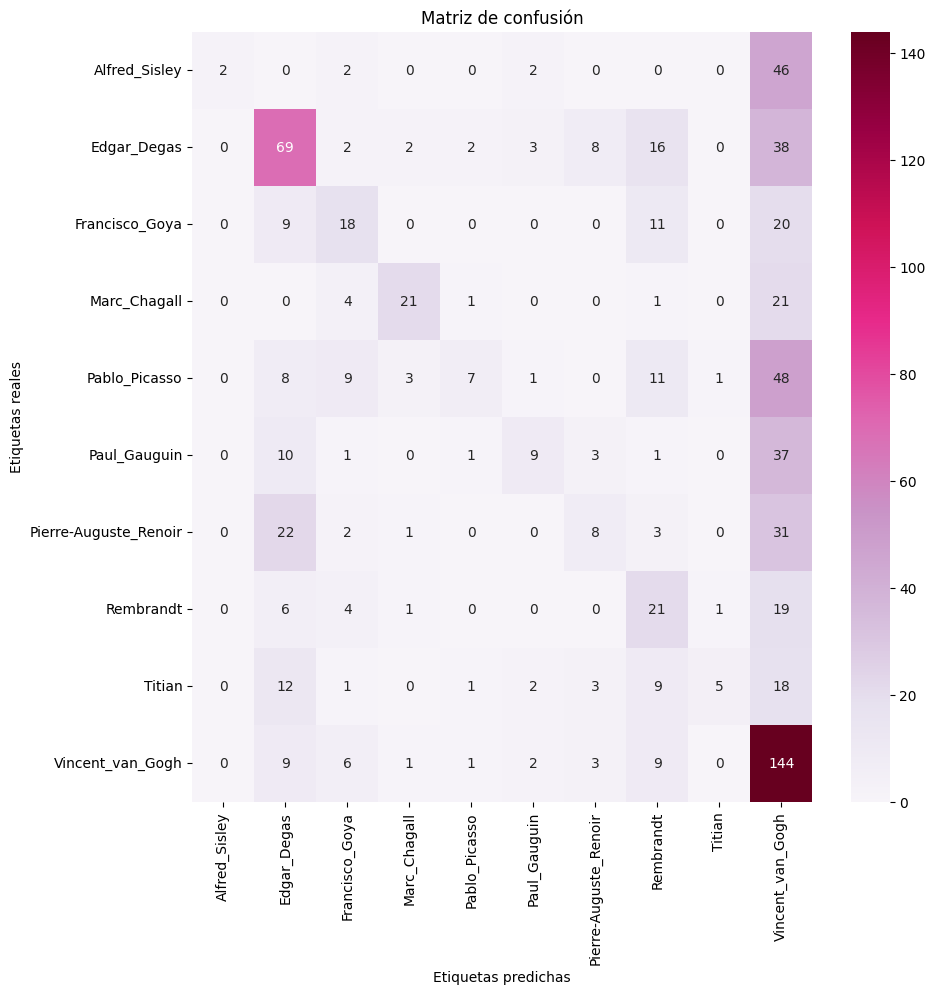

In [67]:
evaluate_prediction(tuned_model, y_test, tuned_pred, labels, plot_size = (10,10))

In [68]:
tuned_model.save('baseline_tuned.h5')